In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## Imports
import warnings
warnings.filterwarnings('ignore')

import sys

if "google.colab" in sys.modules:
    !pip uninstall lightgbm -y
    !pip install lightgbm==3.3.1
    !pip install Levenshtein

import os
import gc
import time
import random
import pickle
import Levenshtein
import difflib
import multiprocessing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lightgbm as lgb
from tqdm.auto import tqdm
from requests import get
from collections import Counter, defaultdict
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

Found existing installation: lightgbm 2.2.3
Uninstalling lightgbm-2.2.3:
  Successfully uninstalled lightgbm-2.2.3
     |████████████████████████████████| 2.0 MB 4.1 MB/s 
     |████████████████████████████████| 258 kB 4.3 MB/s 
     |████████████████████████████████| 1.8 MB 49.8 MB/s 
     |████████████████████████████████| 103 kB 65.6 MB/s 


In [ ]:
def stratified_group_k_fold(X, y, groups, k, seed=None):
    labels_num = np.max(y) + 1
    y_counts_per_group = defaultdict(lambda: np.zeros(labels_num))
    y_distr = Counter()
    for label, g in zip(y, groups):
        y_counts_per_group[g][label] += 1
        y_distr[label] += 1

    y_counts_per_fold = defaultdict(lambda: np.zeros(labels_num))
    groups_per_fold = defaultdict(set)

    def eval_y_counts_per_fold(y_counts, fold):
        y_counts_per_fold[fold] += y_counts
        std_per_label = []
        for label in range(labels_num):
            label_std = np.std([y_counts_per_fold[i][label] / y_distr[label] for i in range(k)])
            std_per_label.append(label_std)
        y_counts_per_fold[fold] -= y_counts
        return np.mean(std_per_label)
    
    groups_and_y_counts = list(y_counts_per_group.items())
    random.Random(seed).shuffle(groups_and_y_counts)

    for g, y_counts in sorted(groups_and_y_counts, key=lambda x: -np.std(x[1])):
        best_fold = None
        min_eval = None
        for i in range(k):
            fold_eval = eval_y_counts_per_fold(y_counts, i)
            if min_eval is None or fold_eval < min_eval:
                min_eval = fold_eval
                best_fold = i
        y_counts_per_fold[best_fold] += y_counts
        groups_per_fold[best_fold].add(g)

    all_groups = set(groups)
    for i in range(k):
        train_groups = all_groups - groups_per_fold[i]
        test_groups = groups_per_fold[i]

        train_indices = [i for i, g in enumerate(groups) if g in train_groups]
        test_indices = [i for i, g in enumerate(groups) if g in test_groups]

        yield train_indices, test_indices

In [ ]:
def get_distribution(y_vals):
    y_distr = Counter(y_vals)
    y_vals_sum = sum(y_distr.values())
    return [f'{y_distr[i] / y_vals_sum:.2%}' for i in range(np.max(y_vals) + 1)]

In [ ]:
## Parameters
class CFG:
    AUTHOR = "kuruton"
    expID = ""
    if "google.colab" in sys.modules:
        expID = get("http://172.28.0.2:9000/api/sessions").json()[0]["name"].split(".")[0].split("-")[0]
    ROOT_DIR = '/content/drive/MyDrive/Kaggle/Foursquare'
    DATASET_DIR = os.path.join(ROOT_DIR, 'Dataset')
    INPUT_DIR = os.path.join(ROOT_DIR, 'Input')
    OUTPUT_DIR = os.path.join(ROOT_DIR, 'Output')
    is_debug = False
    SEED = 2022
    num_neighbors = 20
    num_split = 5
    n_geographic_split = 48
    feat_columns = ['name', 'address', 'city', 
                'state', 'zip', 'url', 
              'phone', 'categories', 'country']
    vec_columns = ['name', 'categories', 'address', 
                  'state', 'url', 'country']

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
seed_everything(CFG.SEED)

In [ ]:
if not os.path.exists(os.path.join(CFG.OUTPUT_DIR, CFG.expID)):
    os.makedirs(os.path.join(CFG.OUTPUT_DIR, CFG.expID))

In [ ]:
%load_ext Cython

In [ ]:
%%cython
def LCS(str S, str T):
    cdef int i, j
    cdef list dp = [[0] * (len(T) + 1) for _ in range(len(S) + 1)]
    for i in range(len(S)):
        for j in range(len(T)):
            dp[i + 1][j + 1] = max(dp[i][j] + (S[i] == T[j]), dp[i + 1][j], dp[i][j + 1], dp[i + 1][j + 1])
    return dp[len(S)][len(T)]

In [ ]:
def recall_knn(df, Neighbors = 10):
    print('Start knn grouped by latlon_section')
    train_df_country = []
    for country, country_df in tqdm(df.groupby('latlon_section')):
        country_df = country_df.reset_index(drop = True)

        neighbors = min(len(country_df), Neighbors)
        knn = KNeighborsRegressor(n_neighbors = neighbors,
                                    metric = 'haversine',
                                    n_jobs = -1)
        knn.fit(country_df[['latitude','longitude']], country_df.index)
        dists, nears = knn.kneighbors(country_df[['latitude', 'longitude']], 
                                        return_distance = True)

        for k in range(neighbors):            
            cur_df = country_df[['id']]
            cur_df['match_id'] = country_df['id'].values[nears[:, k]]
            cur_df['kdist_country'] = dists[:, k]
            cur_df['kneighbors_country'] = k
            
            train_df_country.append(cur_df)
    train_df_country = pd.concat(train_df_country)
    
    print('Start knn')
    train_df = []
    knn = NearestNeighbors(n_neighbors = Neighbors)
    knn.fit(df[['latitude','longitude']], df.index)
    dists, nears = knn.kneighbors(df[['latitude','longitude']])
    
    for k in range(Neighbors):            
        cur_df = df[['id']]
        cur_df['match_id'] = df['id'].values[nears[:, k]]
        cur_df['kdist'] = dists[:, k]
        cur_df['kneighbors'] = k
        train_df.append(cur_df)
    
    train_df = pd.concat(train_df)
    train_df = train_df.merge(train_df_country,
                                 on = ['id', 'match_id'],
                                 how = 'outer')
    del train_df_country
    
    return train_df

In [ ]:
def add_features(df):    
    for col in tqdm(CFG.feat_columns):       
        if col in CFG.vec_columns:
            tv_fit = tfidf_d[col]
            indexs = [id2index_d[i] for i in df['id']]
            match_indexs = [id2index_d[i] for i in df['match_id']]                    
            df[f'{col}_sim'] = tv_fit[indexs].multiply(tv_fit[match_indexs]).sum(axis = 1).A.ravel()
        
        col_values = data.loc[df['id']][col].values.astype(str)
        matcol_values = data.loc[df['match_id']][col].values.astype(str)
        
        geshs = []
        levens = []
        jaros = []
        lcss = []
        for s, match_s in zip(col_values, matcol_values):
            if s != 'nan' and match_s != 'nan':                    
                geshs.append(difflib.SequenceMatcher(None, s, match_s).ratio())
                levens.append(Levenshtein.distance(s, match_s))
                jaros.append(Levenshtein.jaro_winkler(s, match_s))
                lcss.append(LCS(str(s), str(match_s)))
            else:
                geshs.append(np.nan)
                levens.append(np.nan)
                jaros.append(np.nan)
                lcss.append(np.nan)
        
        df[f'{col}_gesh'] = geshs
        df[f'{col}_leven'] = levens
        df[f'{col}_jaro'] = jaros
        df[f'{col}_lcs'] = lcss
        
        if col not in ['phone', 'zip']:
            df[f'{col}_len'] = list(map(len, col_values))
            df[f'match_{col}_len'] = list(map(len, matcol_values)) 
            df[f'{col}_len_diff'] = np.abs(df[f'{col}_len'] - df[f'match_{col}_len'])
            df[f'{col}_nleven'] = df[f'{col}_leven'] / \
                                    df[[f'{col}_len', f'match_{col}_len']].max(axis = 1)
            
            df[f'{col}_nlcsk'] = df[f'{col}_lcs'] / df[f'match_{col}_len']
            df[f'{col}_nlcs'] = df[f'{col}_lcs'] / df[f'{col}_len']
            
            df = df.drop(f'{col}_len', axis = 1)
            df = df.drop(f'match_{col}_len', axis = 1)
            gc.collect()
    
    df['kdist_diff'] = (df['kdist'] - df['kdist_country']) /\
                                df['kdist_country']
    df['kneighbors_mean'] = df[['kneighbors', 'kneighbors_country']].mean(axis = 1)
    
    return df

In [ ]:
def get_id2poi(input_df: pd.DataFrame) -> dict:
    return dict(zip(input_df['id'], input_df['point_of_interest']))

def get_poi2ids(input_df: pd.DataFrame) -> dict:
    return input_df.groupby('point_of_interest')['id'].apply(set).to_dict()

def get_score(input_df: pd.DataFrame):
    scores = []
    for id_str, matches in zip(input_df['id'].to_numpy(), input_df['matches'].to_numpy()):
        targets = poi2ids[id2poi[id_str]]
        preds = set(matches.split())
        score = len((targets & preds)) / len((targets | preds))
        scores.append(score)
    scores = np.array(scores)
    return scores.mean()

def analysis(df):
    print('Num of data: %s' % len(df))
    print('Num of unique id: %s' % df['id'].nunique())
    print('Num of unique poi: %s' % df['point_of_interest'].nunique())
    
    poi_grouped = df.groupby('point_of_interest')['id'].count().reset_index()
    print('Mean num of unique poi: %s' % poi_grouped['id'].mean())

In [ ]:
## Data load
if "google.colab" in sys.modules:
    data_root = CFG.INPUT_DIR
else:
    data_root = '../input/foursquare-location-matching'
data = pd.read_csv(os.path.join(data_root, 'train.csv'))

if CFG.is_debug:
    data = data.sample(n = 10000, random_state = CFG.SEED)
    data = data.reset_index(drop = True)

In [ ]:
## Data split
kf = GroupKFold(n_splits=2)
for i, (trn_idx, val_idx) in enumerate(kf.split(data, 
                                                data['point_of_interest'], 
                                                data['point_of_interest'])):
    data.loc[val_idx, 'set'] = i

print('Num of train data: %s' % len(data))
print(data['set'].value_counts())

valid_data = data[data['set'] == 0]
train_data = data[data['set'] == 1]

print('Train data: ')
analysis(train_data)
print('Valid data: ')
analysis(valid_data)

train_poi = train_data['point_of_interest'].unique().tolist()
valid_poi = valid_data['point_of_interest'].unique().tolist()

print(set(train_poi) & set(valid_poi))

train_ids = train_data['id'].unique().tolist()
valid_ids = valid_data['id'].unique().tolist()
      
print(set(train_ids) & set(valid_ids))
      
tv_ids_d = {}
tv_ids_d['train_ids'] = train_ids
tv_ids_d['valid_ids'] = valid_ids

np.save('tv_ids_d.npy', tv_ids_d)

del train_data, valid_data
gc.collect()

data = data.set_index('id')
# data = data.loc[tv_ids_d['train_ids']]
data = data.reset_index()

Num of train data: 1138812
1.0    569406
0.0    569406
Name: set, dtype: int64
Train data: 
Num of data: 569406
Num of unique id: 569406
Num of unique poi: 369987
Mean num of unique poi: 1.5389892077289202
Valid data: 
Num of data: 569406
Num of unique id: 569406
Num of unique poi: 369985
Mean num of unique poi: 1.5389975269267673
set()
set()


#Add new geographic coordinate classification

In [ ]:
latitude = [-90 + 180 / (CFG.n_geographic_split // 2) * i for i in range(1, CFG.n_geographic_split // 2)]
longitude = [-180 + 360 / CFG.n_geographic_split * i for i in range(CFG.n_geographic_split)]

In [ ]:
latlons = [(lat, lon) for lon in longitude for lat in latitude]
latlons.append((-90, 0))
latlons.append((90, 0))

In [ ]:
!pip install haversine
from haversine import haversine, Unit

In [ ]:
def latlon_section(latlon):
    min_distance = float('inf')
    min_latlon = None
    for i in range(len(latlons)):
        distance = haversine(latlons[i], latlon)
        if distance < min_distance:
            min_distance = distance
            min_latlon = i
    return min_latlon
data['latlon_section'] = data[['latitude', 'longitude']].apply(latlon_section, axis = 1)
data.head()

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,set,latlon_section
0,E_000001272c6c5d,Café Stad Oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,NaN,Bars,P_677e840bb6fc7e,1.0,570
1,E_000002eae2a589,Carioca Manero,-22.907225,-43.178244,NaN,NaN,NaN,NaN,BR,NaN,NaN,Brazilian Restaurants,P_d82910d8382a83,0.0,422
2,E_000007f24ebc95,ร้านตัดผมการาเกด,13.780813,100.484900,NaN,NaN,NaN,NaN,TH,NaN,NaN,Salons / Barbershops,P_b1066599e78477,0.0,864
3,E_000008a8ba4f48,Turkcell,37.844510,27.844202,Adnan Menderes Bulvarı,NaN,NaN,NaN,TR,NaN,NaN,Mobile Phone Shops,P_b2ed86905a4cd3,0.0,660
4,E_00001d92066153,Restaurante Casa Cofiño,43.338196,-4.326821,NaN,Caviedes,Cantabria,NaN,ES,NaN,NaN,Spanish Restaurants,P_809a884d4407fb,0.0,546


<BarContainer object of 402 artists>

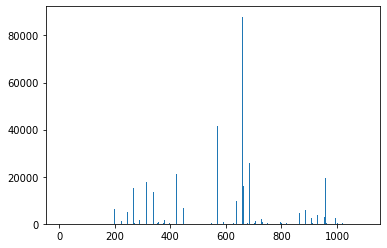

In [ ]:
plt.bar(data['latlon_section'].value_counts().index, data['latlon_section'].value_counts())

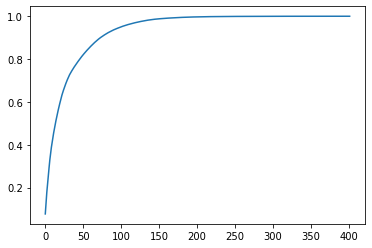

In [ ]:
counts = np.array(data['latlon_section'].value_counts())
counts_sum = counts.sum()
counts = np.sort(counts)[::-1]
plt.plot(np.arange(len(counts)), np.cumsum(counts) / counts_sum)

In [ ]:
## Train data generated by knn
id2index_d = dict(zip(data['id'].values, data.index))

tfidf_d = {}
for col in CFG.vec_columns:
    tfidf = TfidfVectorizer()
    tv_fit = tfidf.fit_transform(data[col].fillna('nan'))
    tfidf_d[col] = tv_fit

train_data = pd.concat([
    recall_knn(data[data["set"]==0], CFG.num_neighbors), 
    recall_knn(data[data["set"]==1], CFG.num_neighbors), 
])

train_data = train_data.reset_index(drop=True)

data = data.set_index('id')
ids = train_data['id'].tolist()
match_ids = train_data['match_id'].tolist()

poi = data.loc[ids]['point_of_interest'].values
match_poi = data.loc[match_ids]['point_of_interest'].values

train_data['label'] = np.array(poi == match_poi, dtype = np.int8)
del poi, match_poi, ids, match_ids
gc.collect()

print('Num of unique id: %s' % train_data['id'].nunique())
print('Num of train data: %s' % len(train_data))
print('Pos rate: %s' % train_data['label'].mean())
print(train_data.sample(5))

Start knn grouped by latlon_section


  0%|          | 0/359 [00:00<?, ?it/s]

Start knn
Start knn grouped by latlon_section


  0%|          | 0/370 [00:00<?, ?it/s]

Start knn
Num of unique id: 1138812
Num of train data: 26547193
Pos rate: 0.07581618892814769
                        id          match_id     kdist  kneighbors  \
9317932   E_5d4bbb74b832a3  E_5fcfb0cda301a7  0.012050        16.0   
18240770  E_b8e4245de6f86e  E_3e9ada75d51b19  0.001570         8.0   
21787390  E_f3a8ef3d48d6bb  E_cf00608aac695c  0.025700        14.0   
21426285  E_514c1a2f58c3d2  E_50eb1129f0fd8c  0.000277        14.0   
11506127  E_3cd471907da4ec  E_c38fa0d93ab8ac       NaN         NaN   

          kdist_country  kneighbors_country  label  
9317932             NaN                 NaN      0  
18240770            NaN                 NaN      0  
21787390            NaN                 NaN      0  
21426285       0.000277                14.0      0  
11506127       0.491857                19.0      0  


In [ ]:
## Eval
data = data.reset_index()

id2poi = get_id2poi(data)
poi2ids = get_poi2ids(data)

eval_df = pd.DataFrame()
eval_df['id'] = data['id'].unique().tolist()
eval_df['match_id'] = eval_df['id']
print('Unique id: %s' % len(eval_df))

eval_df_ = train_data[train_data['label'] == 1][['id', 'match_id']]
eval_df = pd.concat([eval_df, eval_df_])

eval_df = eval_df.groupby('id')['match_id'].\
                        apply(list).reset_index()
eval_df['matches'] = eval_df['match_id'].apply(lambda x: ' '.join(set(x)))
print('Unique id: %s' % len(eval_df))

iou_score = get_score(eval_df)
print('IoU score: %s' % iou_score)

Unique id: 1138812
Unique id: 1138812
IoU score: 0.9227820824079624


In [ ]:
distrs = [get_distribution(train_data["label"])]
index = ['training set']

for fold_ind, (dev_ind, val_ind) in enumerate(stratified_group_k_fold(train_data, train_data["label"], train_data["id"], k=CFG.num_split, seed=CFG.SEED)):
    train_data.loc[val_ind, "fold"] = fold_ind

    dev_y, val_y = train_data.loc[dev_ind, "label"], train_data.loc[val_ind, "label"]
    dev_groups, val_groups = train_data.loc[dev_ind, "id"], train_data.loc[val_ind, "id"]
    
    assert len(set(dev_groups) & set(val_groups)) == 0
    
    distrs.append(get_distribution(dev_y))
    index.append(f'development set - fold {fold_ind}')
    distrs.append(get_distribution(val_y))
    index.append(f'validation set - fold {fold_ind}')

display('Distribution per class:')
pd.DataFrame(distrs, index=index, columns=[f'Label {l}' for l in range(np.max(train_data["label"]) + 1)])

'Distribution per class:'

,Label 0,Label 1
training set,92.42%,7.58%
development set - fold 0,92.42%,7.58%
validation set - fold 0,92.42%,7.58%
development set - fold 1,92.42%,7.58%
validation set - fold 1,92.42%,7.58%
development set - fold 2,92.42%,7.58%
validation set - fold 2,92.42%,7.58%
development set - fold 3,92.42%,7.58%
validation set - fold 3,92.42%,7.58%
development set - fold 4,92.42%,7.58%


# model learning

In [ ]:
data = data.set_index('id')

In [ ]:
features = ['kdist','kneighbors','kdist_country','kneighbors_country', 'kdist_diff', 'kneighbors_mean']

columns = ['name', 'address', 'city', 'state',
       'zip', 'country', 'url', 'phone', 'categories']

for c in columns:
    if c == 'country':
        features += ['country_leven', 'country_sim', 'country_gesh', 'country_nleven']
        continue
    features += [f"{c}_gesh", f"{c}_jaro", f"{c}_lcs", f"{c}_leven"]
    if c == 'city':
        features += [f"{c}_len_diff", f"{c}_nleven", f"{c}_nlcsk", f"{c}_nlcs"]
    if c in ['address', 'categories', 'country', 'name', 'state', 'url']:
        features += [f"{c}_len_diff", f"{c}_nleven", f"{c}_nlcsk", f"{c}_nlcs", f"{c}_sim"]

print(len(features))
print(features)

71
['kdist', 'kneighbors', 'kdist_country', 'kneighbors_country', 'kdist_diff', 'kneighbors_mean', 'name_gesh', 'name_jaro', 'name_lcs', 'name_leven', 'name_len_diff', 'name_nleven', 'name_nlcsk', 'name_nlcs', 'name_sim', 'address_gesh', 'address_jaro', 'address_lcs', 'address_leven', 'address_len_diff', 'address_nleven', 'address_nlcsk', 'address_nlcs', 'address_sim', 'city_gesh', 'city_jaro', 'city_lcs', 'city_leven', 'city_len_diff', 'city_nleven', 'city_nlcsk', 'city_nlcs', 'state_gesh', 'state_jaro', 'state_lcs', 'state_leven', 'state_len_diff', 'state_nleven', 'state_nlcsk', 'state_nlcs', 'state_sim', 'zip_gesh', 'zip_jaro', 'zip_lcs', 'zip_leven', 'country_leven', 'country_sim', 'country_gesh', 'country_nleven', 'url_gesh', 'url_jaro', 'url_lcs', 'url_leven', 'url_len_diff', 'url_nleven', 'url_nlcsk', 'url_nlcs', 'url_sim', 'phone_gesh', 'phone_jaro', 'phone_lcs', 'phone_leven', 'categories_gesh', 'categories_jaro', 'categories_lcs', 'categories_leven', 'categories_len_diff', 'c

In [ ]:
def fit_lgb(X, y, params=None, es_rounds=20, seed=42, N_SPLITS=5, 
             n_class=None, model_dir=None, folds=None):
    models = []
    oof = np.zeros((len(y), 2), dtype=np.float64)
    
    for i in tqdm(range(CFG.num_split)):
        
        print(f"== fold {i} ==")
        trn_idx = folds==((i - 1) % CFG.num_split)
        val_idx = folds==i
        X_train, y_train = X.iloc[trn_idx], y.iloc[trn_idx]
        X_valid, y_valid = X.iloc[val_idx], y.iloc[val_idx]
        
        X_train = add_features(X_train)
        X_valid = add_features(X_valid)
        X_train = X_train[features]
        X_valid = X_valid[features]

        if model_dir is None:
            model = lgb.LGBMClassifier(**params)
            model.fit(
                X_train, y_train, 
                eval_set=[(X_valid, y_valid)],  
                early_stopping_rounds=es_rounds, 
                eval_metric='binary',  
    #             verbose=-1)
                verbose=50)
        else:
            with open(f'{model_dir}/lgb_fold{i}.pkl', 'rb') as f:
                model = pickle.load(f)
            
        pred = model.predict_proba(X_valid)
        oof[val_idx] = pred
        models.append(model)
        
        file = os.path.join(CFG.OUTPUT_DIR, os.path.join(CFG.expID, f'lgb_fold{i}.pkl'))
        pickle.dump(model, open(file, 'wb'))
        print()

        del X_train, X_valid
        gc.collect()

    cv = (oof.argmax(axis=-1) == y).mean()
    print(f"CV-accuracy: {cv}")

    return oof, models

def inference_lgb(models, feat_df):
    pred = np.array([model.predict_proba(feat_df) for model in models])
    pred = np.mean(pred, axis=0)
    return pred

In [ ]:
params = {
    'objective': "binary",
    'learning_rate': 0.2,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': 42,

    'max_depth': 7,   
    'num_leaves': 35, 
    'n_estimators': 1000000, 
    "colsample_bytree": 0.9,
}


oof, models = fit_lgb(train_data, train_data["label"].astype(int), 
                      params=params, n_class=2, 
                      N_SPLITS=CFG.num_split, folds=train_data["fold"].values)

  0%|          | 0/5 [00:00<?, ?it/s]

== fold 0 ==


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

[50]	valid_0's binary_logloss: 0.0459629
[100]	valid_0's binary_logloss: 0.0442988
[150]	valid_0's binary_logloss: 0.0435677
[200]	valid_0's binary_logloss: 0.0431801
[250]	valid_0's binary_logloss: 0.0428741
[300]	valid_0's binary_logloss: 0.0426062
[350]	valid_0's binary_logloss: 0.0423777
[400]	valid_0's binary_logloss: 0.0422066
[450]	valid_0's binary_logloss: 0.0419976
[500]	valid_0's binary_logloss: 0.041863
[550]	valid_0's binary_logloss: 0.0417101
[600]	valid_0's binary_logloss: 0.0416024
[650]	valid_0's binary_logloss: 0.0414989
[700]	valid_0's binary_logloss: 0.0414057
[750]	valid_0's binary_logloss: 0.0413429
[800]	valid_0's binary_logloss: 0.0412678
[850]	valid_0's binary_logloss: 0.0412112
[900]	valid_0's binary_logloss: 0.0411631
[950]	valid_0's binary_logloss: 0.0410975
[1000]	valid_0's binary_logloss: 0.0410314
[1050]	valid_0's binary_logloss: 0.0410002
[1100]	valid_0's binary_logloss: 0.0409469
[1150]	valid_0's binary_logloss: 0.0409113
[1200]	valid_0's binary_logloss:

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

[50]	valid_0's binary_logloss: 0.0460361
[100]	valid_0's binary_logloss: 0.0443274
[150]	valid_0's binary_logloss: 0.0437177
[200]	valid_0's binary_logloss: 0.0432772
[250]	valid_0's binary_logloss: 0.0429684
[300]	valid_0's binary_logloss: 0.0426629
[350]	valid_0's binary_logloss: 0.0424828
[400]	valid_0's binary_logloss: 0.0423335
[450]	valid_0's binary_logloss: 0.0421962
[500]	valid_0's binary_logloss: 0.0420676
[550]	valid_0's binary_logloss: 0.041944
[600]	valid_0's binary_logloss: 0.0418242
[650]	valid_0's binary_logloss: 0.041687
[700]	valid_0's binary_logloss: 0.0416017
[750]	valid_0's binary_logloss: 0.0415002
[800]	valid_0's binary_logloss: 0.0414049
[850]	valid_0's binary_logloss: 0.0413286
[900]	valid_0's binary_logloss: 0.041258
[950]	valid_0's binary_logloss: 0.0411816
[1000]	valid_0's binary_logloss: 0.0411323
[1050]	valid_0's binary_logloss: 0.0410625
[1100]	valid_0's binary_logloss: 0.0410111
[1150]	valid_0's binary_logloss: 0.0409724
[1200]	valid_0's binary_logloss: 0

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

[50]	valid_0's binary_logloss: 0.0457503
[100]	valid_0's binary_logloss: 0.0441394
[150]	valid_0's binary_logloss: 0.0434727
[200]	valid_0's binary_logloss: 0.0429903
[250]	valid_0's binary_logloss: 0.0427157
[300]	valid_0's binary_logloss: 0.042489
[350]	valid_0's binary_logloss: 0.0422898
[400]	valid_0's binary_logloss: 0.0421486
[450]	valid_0's binary_logloss: 0.042005
[500]	valid_0's binary_logloss: 0.041834
[550]	valid_0's binary_logloss: 0.0416943
[600]	valid_0's binary_logloss: 0.0415825
[650]	valid_0's binary_logloss: 0.0415086
[700]	valid_0's binary_logloss: 0.0414239
[750]	valid_0's binary_logloss: 0.0413566
[800]	valid_0's binary_logloss: 0.0412684
[850]	valid_0's binary_logloss: 0.0411986
[900]	valid_0's binary_logloss: 0.04115
[950]	valid_0's binary_logloss: 0.0410851
[1000]	valid_0's binary_logloss: 0.0410361
[1050]	valid_0's binary_logloss: 0.0409989
[1100]	valid_0's binary_logloss: 0.0409509
[1150]	valid_0's binary_logloss: 0.0409167
[1200]	valid_0's binary_logloss: 0.0

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

[50]	valid_0's binary_logloss: 0.0457004
[100]	valid_0's binary_logloss: 0.0439072
[150]	valid_0's binary_logloss: 0.043247
[200]	valid_0's binary_logloss: 0.0428735
[250]	valid_0's binary_logloss: 0.0425381
[300]	valid_0's binary_logloss: 0.0422799
[350]	valid_0's binary_logloss: 0.0420544
[400]	valid_0's binary_logloss: 0.0418893
[450]	valid_0's binary_logloss: 0.041762
[500]	valid_0's binary_logloss: 0.0415822
[550]	valid_0's binary_logloss: 0.0414431
[600]	valid_0's binary_logloss: 0.0413716
[650]	valid_0's binary_logloss: 0.0412607
[700]	valid_0's binary_logloss: 0.0411547
[750]	valid_0's binary_logloss: 0.0410555
[800]	valid_0's binary_logloss: 0.0409864
[850]	valid_0's binary_logloss: 0.0409142
[900]	valid_0's binary_logloss: 0.0408695
[950]	valid_0's binary_logloss: 0.0407808
[1000]	valid_0's binary_logloss: 0.0407184
[1050]	valid_0's binary_logloss: 0.0406838
[1100]	valid_0's binary_logloss: 0.040634
[1150]	valid_0's binary_logloss: 0.0405864
[1200]	valid_0's binary_logloss: 0

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

[50]	valid_0's binary_logloss: 0.0457463
[100]	valid_0's binary_logloss: 0.0440802
[150]	valid_0's binary_logloss: 0.0433662
[200]	valid_0's binary_logloss: 0.0429843
[250]	valid_0's binary_logloss: 0.0426232
[300]	valid_0's binary_logloss: 0.0424874
[350]	valid_0's binary_logloss: 0.0422436
[400]	valid_0's binary_logloss: 0.0420598
[450]	valid_0's binary_logloss: 0.0418641
[500]	valid_0's binary_logloss: 0.0417425
[550]	valid_0's binary_logloss: 0.0416405
[600]	valid_0's binary_logloss: 0.0415632
[650]	valid_0's binary_logloss: 0.0414792
[700]	valid_0's binary_logloss: 0.0414089
[750]	valid_0's binary_logloss: 0.0413334
[800]	valid_0's binary_logloss: 0.0412392
[850]	valid_0's binary_logloss: 0.041188
[900]	valid_0's binary_logloss: 0.0411213
[950]	valid_0's binary_logloss: 0.0410587
[1000]	valid_0's binary_logloss: 0.0409964
[1050]	valid_0's binary_logloss: 0.0409153
[1100]	valid_0's binary_logloss: 0.0408779
[1150]	valid_0's binary_logloss: 0.0408398
[1200]	valid_0's binary_logloss:

In [ ]:
train_data["pred"] = oof[:, -1]

#Check Feature Importances

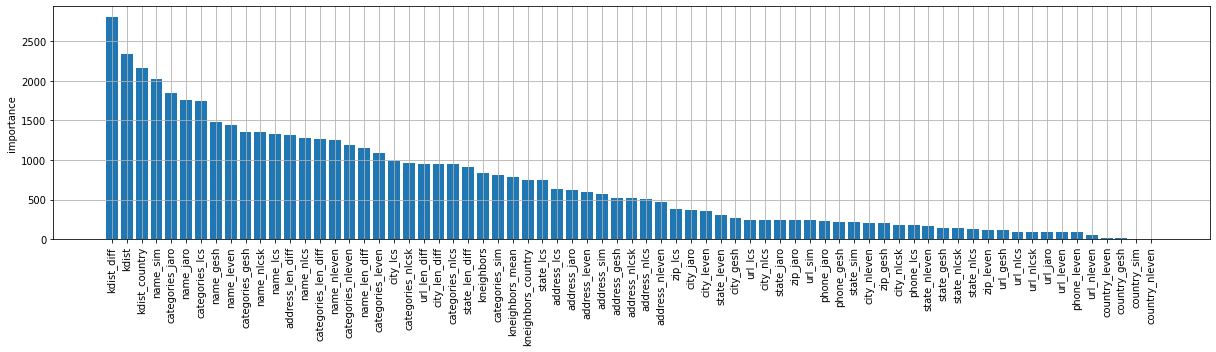

In [ ]:
def plot_importances(models):
    importance_df = pd.DataFrame(models[0].feature_importances_, 
                                 index=features, 
                                 columns=['importance'])\
                        .sort_values("importance", ascending=False)

    plt.subplots(figsize=(len(features) // 4, 5))
    plt.bar(importance_df.index, importance_df.importance)
    plt.grid()
    plt.xticks(rotation=90)
    plt.ylabel("importance")
    plt.tight_layout()
    plt.show()

plot_importances(models)

#Check CV

In [ ]:
!pip install optuna

     |████████████████████████████████| 308 kB 4.3 MB/s 
     |████████████████████████████████| 81 kB 8.9 MB/s 
     |████████████████████████████████| 210 kB 59.4 MB/s 
     |████████████████████████████████| 78 kB 6.1 MB/s 
     |████████████████████████████████| 49 kB 5.6 MB/s 
     |████████████████████████████████| 112 kB 65.3 MB/s 
     |████████████████████████████████| 146 kB 63.8 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=eabe5304d81b8e3298b8683bd9fafe32d98c7f64d23546e0f73859976b4c6c01
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
def post_process(df):
    id2match = dict(zip(df['id'].values, df['matches'].str.split()))

    for base, match in df[['id', 'matches']].values:
        match = match.split()
        if len(match) == 1:        
            continue

        for m in match:
            if base not in id2match[m]:
                id2match[m].append(base)
    df['matches'] = df['id'].map(id2match).map(' '.join)
    return df 

In [ ]:
import optuna

def objective(trial):
    x = trial.suggest_uniform('threshold', 0, 1)
    train_pred_df = train_data[train_data['pred'] > x][['id', 'match_id']]
    out_df = pd.DataFrame()
    out_df['id'] = train_data['id'].unique().tolist()
    out_df['match_id'] = out_df['id']
    out_df = pd.concat([out_df, train_pred_df])
    out_df = out_df.groupby('id')['match_id'].\
                        apply(list).reset_index()
    out_df['matches'] = out_df['match_id'].apply(lambda x: ' '.join(set(x)))
    out_df = post_process(out_df)

    score = get_score(out_df)
    print(f"CV: {score:.6f}")
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2022-05-20 22:11:29,528] A new study created in memory with name: no-name-7cb831e1-18f5-43a1-bbe0-23874feab415
[I 2022-05-20 22:12:18,599] Trial 0 finished with value: 0.7710050477780598 and parameters: {'threshold': 0.1185264421885075}. Best is trial 0 with value: 0.7710050477780598.


CV: 0.771005


[I 2022-05-20 22:12:56,876] Trial 1 finished with value: 0.7414574126100024 and parameters: {'threshold': 0.9777641916516759}. Best is trial 0 with value: 0.7710050477780598.


CV: 0.741457
CV: 0.811402


[I 2022-05-20 22:13:59,916] Trial 2 finished with value: 0.8114015864976807 and parameters: {'threshold': 0.23950466496975364}. Best is trial 2 with value: 0.8114015864976807.
[I 2022-05-20 22:14:44,582] Trial 3 finished with value: 0.7357029448869395 and parameters: {'threshold': 0.07194713426251365}. Best is trial 2 with value: 0.8114015864976807.


CV: 0.735703


[I 2022-05-20 22:15:27,199] Trial 4 finished with value: 0.8233233081771967 and parameters: {'threshold': 0.31403206760470015}. Best is trial 4 with value: 0.8233233081771967.


CV: 0.823323


[I 2022-05-20 22:16:08,553] Trial 5 finished with value: 0.8190027774586942 and parameters: {'threshold': 0.2826827277512912}. Best is trial 4 with value: 0.8233233081771967.


CV: 0.819003


[I 2022-05-20 22:16:48,951] Trial 6 finished with value: 0.7983359338245294 and parameters: {'threshold': 0.9057536667432678}. Best is trial 4 with value: 0.8233233081771967.


CV: 0.798336


[I 2022-05-20 22:17:31,161] Trial 7 finished with value: 0.8304311486463626 and parameters: {'threshold': 0.3831863535993115}. Best is trial 7 with value: 0.8304311486463626.


CV: 0.830431


[I 2022-05-20 22:18:14,221] Trial 8 finished with value: 0.8238923077985036 and parameters: {'threshold': 0.3184801906806519}. Best is trial 7 with value: 0.8304311486463626.


CV: 0.823892


[I 2022-05-20 22:18:56,061] Trial 9 finished with value: 0.8344766659434695 and parameters: {'threshold': 0.4429923721754083}. Best is trial 9 with value: 0.8344766659434695.


CV: 0.834477


[I 2022-05-20 22:19:37,519] Trial 10 finished with value: 0.8364117362819969 and parameters: {'threshold': 0.6436889816097745}. Best is trial 10 with value: 0.8364117362819969.


CV: 0.836412


[I 2022-05-20 22:20:19,901] Trial 11 finished with value: 0.8366191483671205 and parameters: {'threshold': 0.6375562083398334}. Best is trial 11 with value: 0.8366191483671205.


CV: 0.836619


[I 2022-05-20 22:21:01,048] Trial 12 finished with value: 0.8357520741349629 and parameters: {'threshold': 0.6597483254886212}. Best is trial 11 with value: 0.8366191483671205.


CV: 0.835752


[I 2022-05-20 22:21:42,285] Trial 13 finished with value: 0.8365512848862122 and parameters: {'threshold': 0.6397653168761548}. Best is trial 11 with value: 0.8366191483671205.


CV: 0.836551


[I 2022-05-20 22:22:23,508] Trial 14 finished with value: 0.8367693556556517 and parameters: {'threshold': 0.6335034425337811}. Best is trial 14 with value: 0.8367693556556517.


CV: 0.836769


[I 2022-05-20 22:23:03,419] Trial 15 finished with value: 0.823871526992018 and parameters: {'threshold': 0.8011873688075201}. Best is trial 14 with value: 0.8367693556556517.


CV: 0.823872
CV: 0.837337


[I 2022-05-20 22:23:46,910] Trial 16 finished with value: 0.8373365288600578 and parameters: {'threshold': 0.5226840730056935}. Best is trial 16 with value: 0.8373365288600578.


CV: 0.837338


[I 2022-05-20 22:24:36,054] Trial 17 finished with value: 0.8373381032461666 and parameters: {'threshold': 0.5241151587394559}. Best is trial 17 with value: 0.8373381032461666.


CV: 0.836860


[I 2022-05-20 22:25:17,842] Trial 18 finished with value: 0.8368602449663206 and parameters: {'threshold': 0.5034653079638285}. Best is trial 17 with value: 0.8373381032461666.
[I 2022-05-20 22:26:00,366] Trial 19 finished with value: 0.8370340089175395 and parameters: {'threshold': 0.5111824864207756}. Best is trial 17 with value: 0.8373381032461666.


CV: 0.837034


[I 2022-05-20 22:26:40,230] Trial 20 finished with value: 0.8188397421561341 and parameters: {'threshold': 0.8324321227413072}. Best is trial 17 with value: 0.8373381032461666.


CV: 0.818840
CV: 0.837729


[I 2022-05-20 22:27:21,722] Trial 21 finished with value: 0.8377287871648953 and parameters: {'threshold': 0.5598152822365299}. Best is trial 21 with value: 0.8377287871648953.


CV: 0.837162


[I 2022-05-20 22:28:03,400] Trial 22 finished with value: 0.8371616691890723 and parameters: {'threshold': 0.5148048830194131}. Best is trial 21 with value: 0.8377287871648953.
[I 2022-05-20 22:28:44,305] Trial 23 finished with value: 0.8318590413488236 and parameters: {'threshold': 0.7281573624242584}. Best is trial 21 with value: 0.8377287871648953.


CV: 0.831859
CV: 0.833125


[I 2022-05-20 22:29:26,427] Trial 24 finished with value: 0.8331252149449048 and parameters: {'threshold': 0.4197213348009127}. Best is trial 21 with value: 0.8377287871648953.


CV: 0.837729


[I 2022-05-20 22:30:09,029] Trial 25 finished with value: 0.837729101170514 and parameters: {'threshold': 0.5712882729098775}. Best is trial 25 with value: 0.837729101170514.
[I 2022-05-20 22:30:50,510] Trial 26 finished with value: 0.8377153021576421 and parameters: {'threshold': 0.5685986712741139}. Best is trial 25 with value: 0.837729101170514.


CV: 0.837715
CV: 0.831218


[I 2022-05-20 22:31:31,446] Trial 27 finished with value: 0.8312178900118412 and parameters: {'threshold': 0.7358977558505658}. Best is trial 25 with value: 0.837729101170514.
[I 2022-05-20 22:32:11,757] Trial 28 finished with value: 0.8375020750813561 and parameters: {'threshold': 0.5928766382073655}. Best is trial 25 with value: 0.837729101170514.


CV: 0.837502


[I 2022-05-20 22:32:52,725] Trial 29 finished with value: 0.831735387352374 and parameters: {'threshold': 0.7300751806766964}. Best is trial 25 with value: 0.837729101170514.


CV: 0.831735


[I 2022-05-20 22:33:35,904] Trial 30 finished with value: 0.8062240493072972 and parameters: {'threshold': 0.21580531446628226}. Best is trial 25 with value: 0.837729101170514.


CV: 0.806224


[I 2022-05-20 22:34:16,046] Trial 31 finished with value: 0.8375447767756422 and parameters: {'threshold': 0.5857812587529154}. Best is trial 25 with value: 0.837729101170514.


CV: 0.837545


[I 2022-05-20 22:34:57,386] Trial 32 finished with value: 0.8377293912514954 and parameters: {'threshold': 0.5709851519496222}. Best is trial 32 with value: 0.8377293912514954.


CV: 0.837729
CV: 0.835078


[I 2022-05-20 22:35:39,430] Trial 33 finished with value: 0.835077691404514 and parameters: {'threshold': 0.4558806591934967}. Best is trial 32 with value: 0.8377293912514954.
[I 2022-05-20 22:36:22,058] Trial 34 finished with value: 0.837723976840527 and parameters: {'threshold': 0.5708800995945569}. Best is trial 32 with value: 0.8377293912514954.


CV: 0.837724


[I 2022-05-20 22:37:03,778] Trial 35 finished with value: 0.8302596917498092 and parameters: {'threshold': 0.38122565733288094}. Best is trial 32 with value: 0.8377293912514954.


CV: 0.830260


[I 2022-05-20 22:37:45,213] Trial 36 finished with value: 0.8342042930778998 and parameters: {'threshold': 0.6922284394204288}. Best is trial 32 with value: 0.8377293912514954.


CV: 0.834204


[I 2022-05-20 22:38:26,804] Trial 37 finished with value: 0.8248908674741898 and parameters: {'threshold': 0.7936834444868226}. Best is trial 32 with value: 0.8377293912514954.


CV: 0.824891


[I 2022-05-20 22:39:04,864] Trial 38 finished with value: 0.7062672781550996 and parameters: {'threshold': 0.9926509018247853}. Best is trial 32 with value: 0.8377293912514954.


CV: 0.706267


[I 2022-05-20 22:39:45,387] Trial 39 finished with value: 0.8377034881804796 and parameters: {'threshold': 0.5737610921187543}. Best is trial 32 with value: 0.8377293912514954.


CV: 0.837703


[I 2022-05-20 22:40:28,789] Trial 40 finished with value: 0.8290113039788612 and parameters: {'threshold': 0.3665642691723828}. Best is trial 32 with value: 0.8377293912514954.


CV: 0.829011


[I 2022-05-20 22:41:10,062] Trial 41 finished with value: 0.8377077954874929 and parameters: {'threshold': 0.5738055011034454}. Best is trial 32 with value: 0.8377293912514954.


CV: 0.837708


[I 2022-05-20 22:41:52,582] Trial 42 finished with value: 0.8358033343797469 and parameters: {'threshold': 0.47281575757498157}. Best is trial 32 with value: 0.8377293912514954.


CV: 0.835803


[I 2022-05-20 22:42:34,742] Trial 43 finished with value: 0.8376830949740441 and parameters: {'threshold': 0.5530109166325953}. Best is trial 32 with value: 0.8377293912514954.


CV: 0.837683
CV: 0.832581


[I 2022-05-20 22:43:16,475] Trial 44 finished with value: 0.8325805948534648 and parameters: {'threshold': 0.41094295665356273}. Best is trial 32 with value: 0.8377293912514954.
[I 2022-05-20 22:43:57,880] Trial 45 finished with value: 0.8373960847740817 and parameters: {'threshold': 0.603809145604916}. Best is trial 32 with value: 0.8377293912514954.


CV: 0.837396


[I 2022-05-20 22:44:47,833] Trial 46 finished with value: 0.6433859837923646 and parameters: {'threshold': 0.02509033377688752}. Best is trial 32 with value: 0.8377293912514954.


CV: 0.643386


[I 2022-05-20 22:45:28,631] Trial 47 finished with value: 0.8344336209818751 and parameters: {'threshold': 0.6886062759894883}. Best is trial 32 with value: 0.8377293912514954.


CV: 0.834434


[I 2022-05-20 22:46:20,325] Trial 48 finished with value: 0.8352876415610433 and parameters: {'threshold': 0.46087282750372727}. Best is trial 32 with value: 0.8377293912514954.


CV: 0.835288


[I 2022-05-20 22:47:08,547] Trial 49 finished with value: 0.8145261332134776 and parameters: {'threshold': 0.2559277061230489}. Best is trial 32 with value: 0.8377293912514954.


CV: 0.814526
CV: 0.824575


[I 2022-05-20 22:47:51,069] Trial 50 finished with value: 0.8245748583191184 and parameters: {'threshold': 0.32447867193628577}. Best is trial 32 with value: 0.8377293912514954.
[I 2022-05-20 22:48:33,058] Trial 51 finished with value: 0.8376161803333559 and parameters: {'threshold': 0.5432268083047347}. Best is trial 32 with value: 0.8377293912514954.


CV: 0.837616


[I 2022-05-20 22:49:14,718] Trial 52 finished with value: 0.8372951476662757 and parameters: {'threshold': 0.6107547952719021}. Best is trial 32 with value: 0.8377293912514954.


CV: 0.837295


[I 2022-05-20 22:49:57,247] Trial 53 finished with value: 0.8344745596356463 and parameters: {'threshold': 0.6873286132473463}. Best is trial 32 with value: 0.8377293912514954.


CV: 0.834475


[I 2022-05-20 22:50:40,609] Trial 54 finished with value: 0.8360913350779088 and parameters: {'threshold': 0.4797536212049757}. Best is trial 32 with value: 0.8377293912514954.


CV: 0.836091


[I 2022-05-20 22:51:22,715] Trial 55 finished with value: 0.8358126934524129 and parameters: {'threshold': 0.6578998992832829}. Best is trial 32 with value: 0.8377293912514954.


CV: 0.835813
CV: 0.837720


[I 2022-05-20 22:52:04,934] Trial 56 finished with value: 0.837720304760374 and parameters: {'threshold': 0.5583902445957923}. Best is trial 32 with value: 0.8377293912514954.
[I 2022-05-20 22:52:45,559] Trial 57 finished with value: 0.8370405945720203 and parameters: {'threshold': 0.6232215582002373}. Best is trial 32 with value: 0.8377293912514954.


CV: 0.837041


[I 2022-05-20 22:53:27,840] Trial 58 finished with value: 0.8376735468511001 and parameters: {'threshold': 0.5520999399903944}. Best is trial 32 with value: 0.8377293912514954.


CV: 0.837674


[I 2022-05-20 22:54:08,825] Trial 59 finished with value: 0.8365372354856601 and parameters: {'threshold': 0.492852573295979}. Best is trial 32 with value: 0.8377293912514954.


CV: 0.836537


[I 2022-05-20 22:54:52,147] Trial 60 finished with value: 0.8330190251440772 and parameters: {'threshold': 0.41823213014966404}. Best is trial 32 with value: 0.8377293912514954.


CV: 0.833019


[I 2022-05-20 22:55:33,017] Trial 61 finished with value: 0.8377277734441693 and parameters: {'threshold': 0.5614560567397436}. Best is trial 32 with value: 0.8377293912514954.


CV: 0.837728
CV: 0.837560


[I 2022-05-20 22:56:14,888] Trial 62 finished with value: 0.8375595465459347 and parameters: {'threshold': 0.5396692144648715}. Best is trial 32 with value: 0.8377293912514954.
[I 2022-05-20 22:56:55,165] Trial 63 finished with value: 0.8370818675394253 and parameters: {'threshold': 0.6203473408498001}. Best is trial 32 with value: 0.8377293912514954.


CV: 0.837082


[I 2022-05-20 22:57:38,398] Trial 64 finished with value: 0.8369636245573558 and parameters: {'threshold': 0.5068259099085445}. Best is trial 32 with value: 0.8377293912514954.


CV: 0.836964


[I 2022-05-20 22:58:18,778] Trial 65 finished with value: 0.8357558198019729 and parameters: {'threshold': 0.6597228172173872}. Best is trial 32 with value: 0.8377293912514954.


CV: 0.835756
CV: 0.837655


[I 2022-05-20 22:59:02,720] Trial 66 finished with value: 0.8376547727188732 and parameters: {'threshold': 0.5761161247432665}. Best is trial 32 with value: 0.8377293912514954.
[I 2022-05-20 22:59:41,801] Trial 67 finished with value: 0.7762662410103216 and parameters: {'threshold': 0.94622790384903}. Best is trial 32 with value: 0.8377293912514954.


CV: 0.776266


[I 2022-05-20 23:00:25,823] Trial 68 finished with value: 0.7979055429484877 and parameters: {'threshold': 0.1845712402022096}. Best is trial 32 with value: 0.8377293912514954.


CV: 0.797906


[I 2022-05-20 23:01:08,212] Trial 69 finished with value: 0.834634062392248 and parameters: {'threshold': 0.4470573410696178}. Best is trial 32 with value: 0.8377293912514954.


CV: 0.834634


[I 2022-05-20 23:01:49,400] Trial 70 finished with value: 0.8283856019466964 and parameters: {'threshold': 0.7655357907207927}. Best is trial 32 with value: 0.8377293912514954.


CV: 0.828386


[I 2022-05-20 23:02:30,018] Trial 71 finished with value: 0.837723439688798 and parameters: {'threshold': 0.5575754719443914}. Best is trial 32 with value: 0.8377293912514954.


CV: 0.837723


[I 2022-05-20 23:03:14,225] Trial 72 finished with value: 0.8376401419088975 and parameters: {'threshold': 0.5454005224117987}. Best is trial 32 with value: 0.8377293912514954.


CV: 0.837640


[I 2022-05-20 23:03:54,950] Trial 73 finished with value: 0.8375009501716194 and parameters: {'threshold': 0.5906746756857738}. Best is trial 32 with value: 0.8377293912514954.


CV: 0.837501


[I 2022-05-20 23:04:37,018] Trial 74 finished with value: 0.8372473847575819 and parameters: {'threshold': 0.5194585876514943}. Best is trial 32 with value: 0.8377293912514954.


CV: 0.837247


[I 2022-05-20 23:05:18,675] Trial 75 finished with value: 0.8364860891319768 and parameters: {'threshold': 0.6418834159983289}. Best is trial 32 with value: 0.8377293912514954.


CV: 0.836486


[I 2022-05-20 23:05:58,967] Trial 76 finished with value: 0.8339880830540206 and parameters: {'threshold': 0.6959572220690663}. Best is trial 32 with value: 0.8377293912514954.


CV: 0.833988


[I 2022-05-20 23:06:40,655] Trial 77 finished with value: 0.8377456302937435 and parameters: {'threshold': 0.5663732035899649}. Best is trial 77 with value: 0.8377456302937435.


CV: 0.837746


[I 2022-05-20 23:07:23,353] Trial 78 finished with value: 0.8362995108589544 and parameters: {'threshold': 0.4851875792512643}. Best is trial 77 with value: 0.8377456302937435.


CV: 0.836300
CV: 0.837410


[I 2022-05-20 23:08:03,791] Trial 79 finished with value: 0.8374097727966893 and parameters: {'threshold': 0.6034223333519582}. Best is trial 77 with value: 0.8377456302937435.
[I 2022-05-20 23:08:45,598] Trial 80 finished with value: 0.837349750341051 and parameters: {'threshold': 0.5252023328817136}. Best is trial 77 with value: 0.8377456302937435.


CV: 0.837350


[I 2022-05-20 23:09:27,484] Trial 81 finished with value: 0.8375941086356112 and parameters: {'threshold': 0.5802781238224264}. Best is trial 77 with value: 0.8377456302937435.


CV: 0.837594


[I 2022-05-20 23:10:10,366] Trial 82 finished with value: 0.837688288613262 and parameters: {'threshold': 0.5550948736530773}. Best is trial 77 with value: 0.8377456302937435.


CV: 0.837688


[I 2022-05-20 23:10:51,364] Trial 83 finished with value: 0.836707644134522 and parameters: {'threshold': 0.6350770328421316}. Best is trial 77 with value: 0.8377456302937435.


CV: 0.836708
CV: 0.837761


[I 2022-05-20 23:11:33,194] Trial 84 finished with value: 0.8377610279973897 and parameters: {'threshold': 0.5651921646700557}. Best is trial 84 with value: 0.8377610279973897.
[I 2022-05-20 23:12:15,429] Trial 85 finished with value: 0.8365574846062489 and parameters: {'threshold': 0.49379086315294296}. Best is trial 84 with value: 0.8377610279973897.


CV: 0.836557
CV: 0.834066


[I 2022-05-20 23:12:56,749] Trial 86 finished with value: 0.8340659804778013 and parameters: {'threshold': 0.4364592058476835}. Best is trial 84 with value: 0.8377610279973897.
[I 2022-05-20 23:13:38,959] Trial 87 finished with value: 0.8373769034755744 and parameters: {'threshold': 0.5278219325680461}. Best is trial 84 with value: 0.8377610279973897.


CV: 0.837377


[I 2022-05-20 23:14:19,336] Trial 88 finished with value: 0.8354606245200814 and parameters: {'threshold': 0.6677176211305319}. Best is trial 84 with value: 0.8377610279973897.


CV: 0.835461


[I 2022-05-20 23:15:01,033] Trial 89 finished with value: 0.8374184398676922 and parameters: {'threshold': 0.6026205424098356}. Best is trial 84 with value: 0.8377610279973897.


CV: 0.837418


[I 2022-05-20 23:15:43,355] Trial 90 finished with value: 0.8377267037313856 and parameters: {'threshold': 0.561431697333662}. Best is trial 84 with value: 0.8377610279973897.


CV: 0.837727


[I 2022-05-20 23:16:25,142] Trial 91 finished with value: 0.8377635896784575 and parameters: {'threshold': 0.5651086032242794}. Best is trial 91 with value: 0.8377635896784575.


CV: 0.837764


[I 2022-05-20 23:17:05,947] Trial 92 finished with value: 0.8377002415114991 and parameters: {'threshold': 0.5736343838161607}. Best is trial 91 with value: 0.8377635896784575.


CV: 0.837700


[I 2022-05-20 23:17:49,075] Trial 93 finished with value: 0.8369042963429101 and parameters: {'threshold': 0.50496012496547}. Best is trial 91 with value: 0.8377635896784575.


CV: 0.836904
CV: 0.837157


[I 2022-05-20 23:18:29,579] Trial 94 finished with value: 0.837156847232998 and parameters: {'threshold': 0.6175307399171319}. Best is trial 91 with value: 0.8377635896784575.
[I 2022-05-20 23:19:11,618] Trial 95 finished with value: 0.8375056329203721 and parameters: {'threshold': 0.5371109709948068}. Best is trial 91 with value: 0.8377635896784575.


CV: 0.837506
CV: 0.835810


[I 2022-05-20 23:19:52,669] Trial 96 finished with value: 0.8358104958038974 and parameters: {'threshold': 0.47310431221122917}. Best is trial 91 with value: 0.8377635896784575.
[I 2022-05-20 23:20:33,903] Trial 97 finished with value: 0.833252477608173 and parameters: {'threshold': 0.7083560280433493}. Best is trial 91 with value: 0.8377635896784575.


CV: 0.833252


[I 2022-05-20 23:21:15,624] Trial 98 finished with value: 0.8374929245374438 and parameters: {'threshold': 0.5891294568310267}. Best is trial 91 with value: 0.8377635896784575.


CV: 0.837493


[I 2022-05-20 23:21:57,511] Trial 99 finished with value: 0.8377290608156146 and parameters: {'threshold': 0.5634831976517124}. Best is trial 91 with value: 0.8377635896784575.


CV: 0.837729


In [ ]:
threshold = study.best_params['threshold']
threshold

0.5651086032242794

In [ ]:
study.best_value

0.8377635896784575

In [ ]:
train_pred_df = train_data[train_data['pred'] > threshold][['id', 'match_id']]
out_df = pd.DataFrame()
out_df['id'] = train_data['id'].unique().tolist()
out_df['match_id'] = out_df['id']
out_df = pd.concat([out_df, train_pred_df])
out_df = out_df.groupby('id')['match_id'].\
                    apply(list).reset_index()
out_df['matches'] = out_df['match_id'].apply(lambda x: ' '.join(set(x)))
out_df = post_process(out_df)

score = get_score(out_df)
print(f"CV: {score:.6f}")

CV: 0.837764
